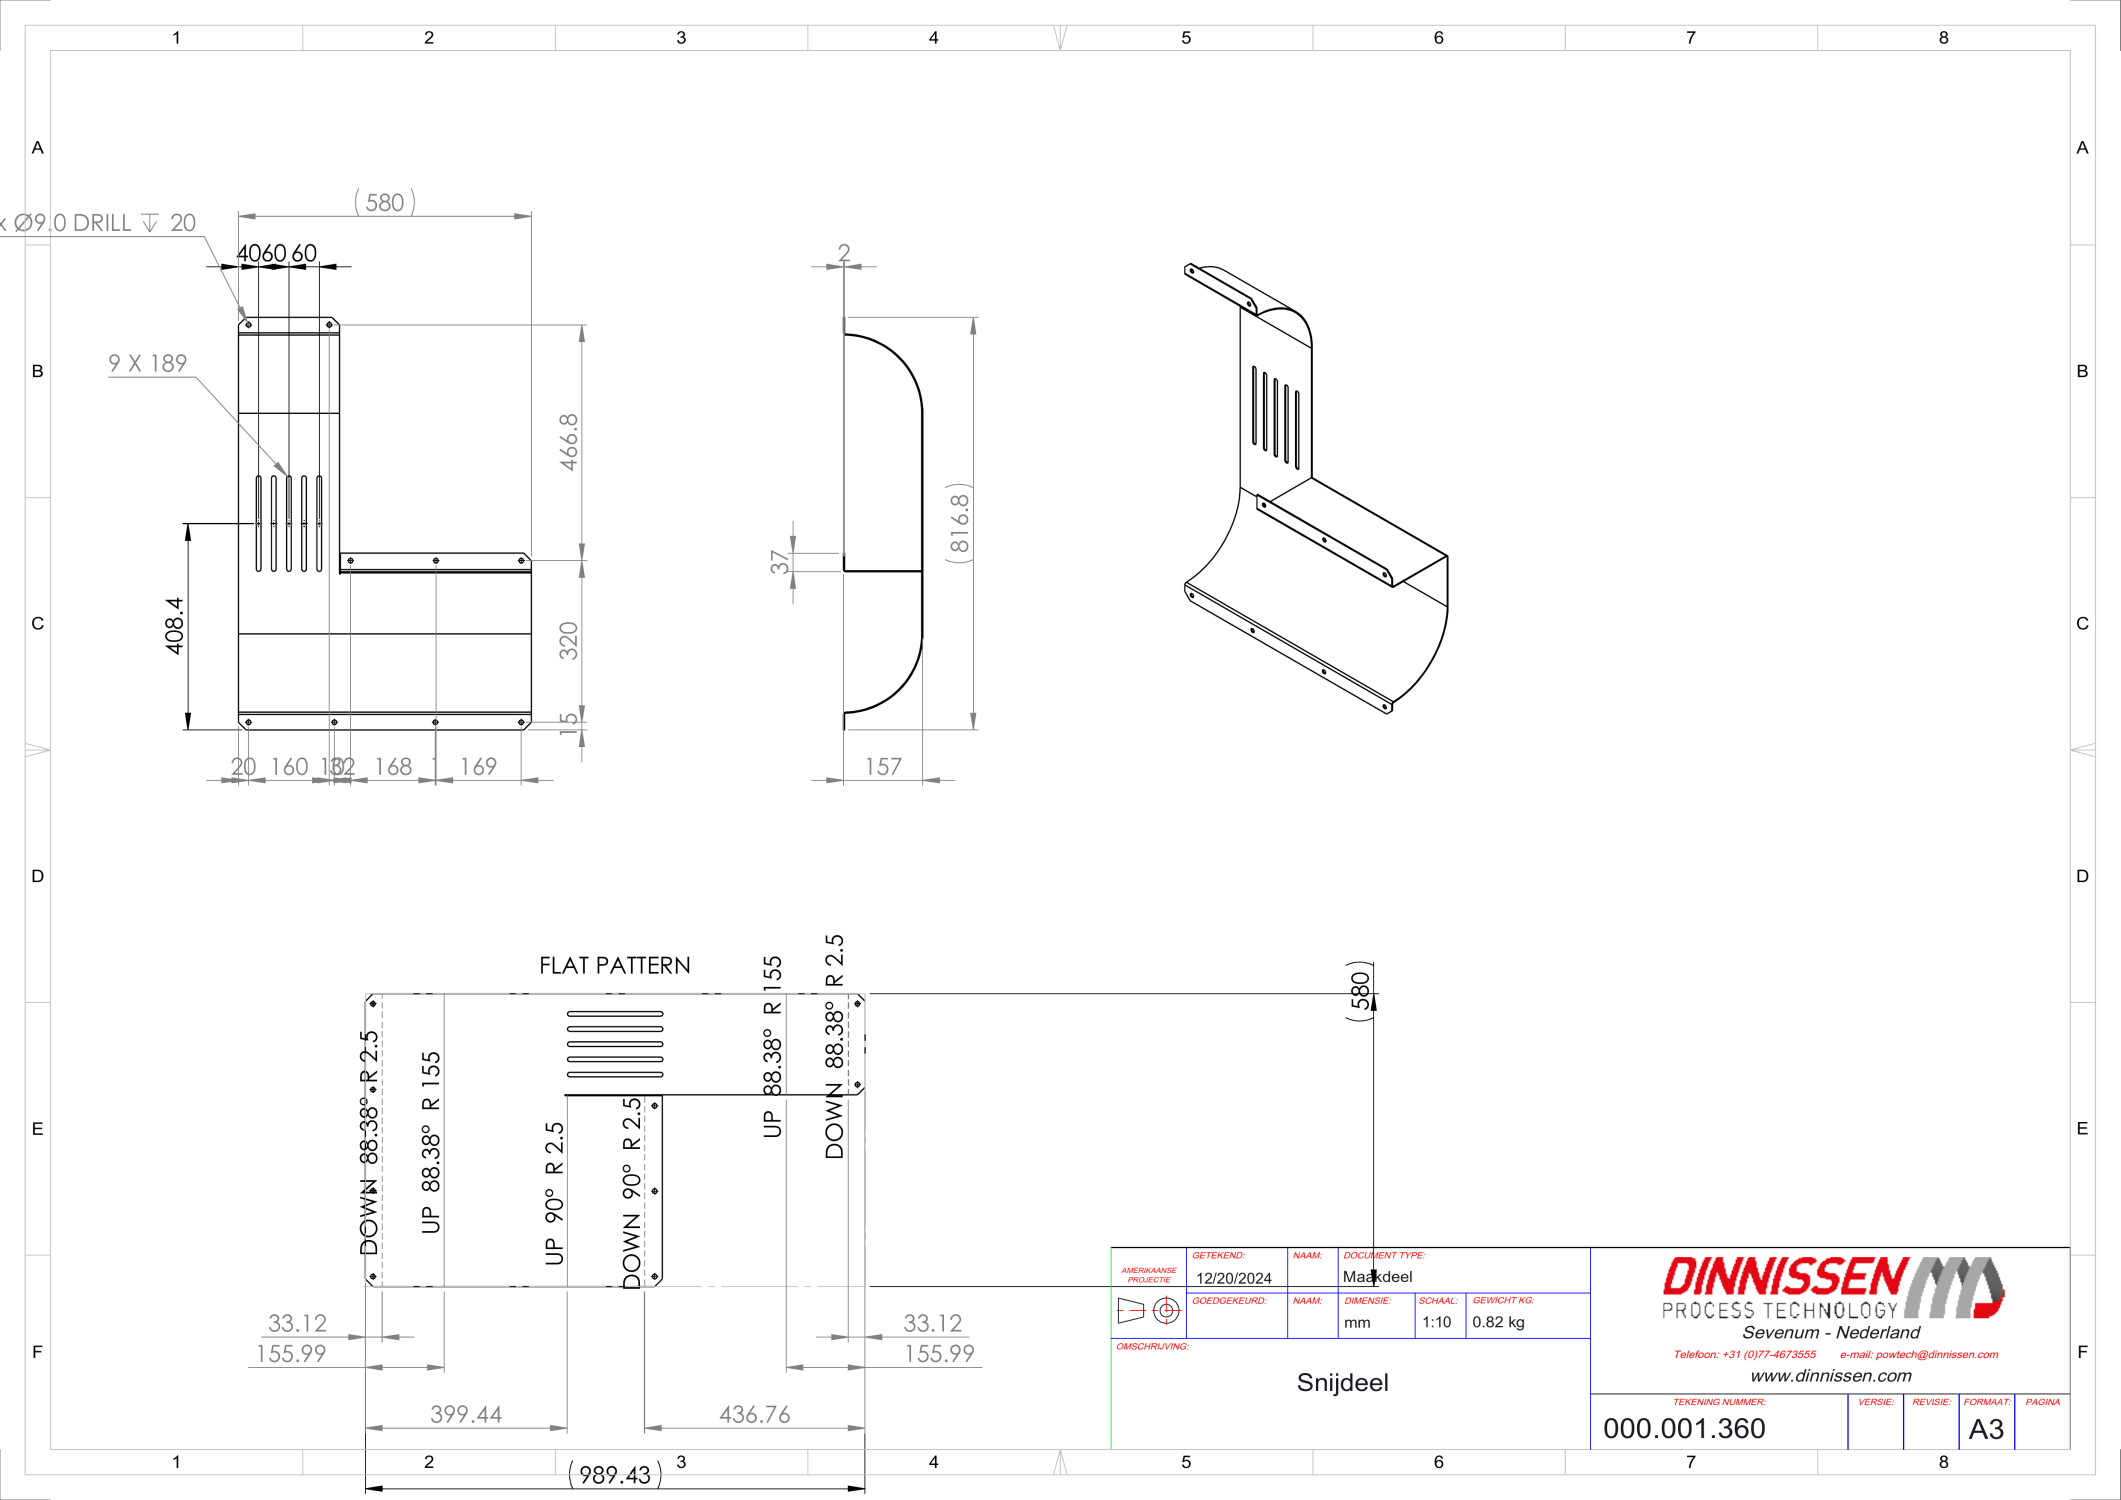

In [1]:
import math
from glob import glob
import os

import cv2
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
from imutils import resize
from sklearn.metrics import euclidean_distances
from tqdm import tqdm
from scoring import *
from border_and_title import *

# f = "../../data/original/Ugly/10.pdf"
# f = "../../data/original/Ugly/2.pdf"
# f = "../../data/original/Ugly/3.pdf"
# f = "../../data/original/Ugly/000.895.652.pdf"
# f = "../../data/original/Ugly/000.001.423.pdf"
f = "../../data/original/Ugly/000.001.360.pdf"
# f = "../../data/original/Ugly/000.000.537.pdf"
# f = "../../data/original/Good/300-014823.pdf"
# f = "../../data/original/Good/300-014822.pdf"

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
color = (255, 0, 0)
thickness = 2

pages = convert_from_path(f, dpi=300)
img = np.array(pages[0])
img = im_resize(img)
img_comp = img.copy()

Image.fromarray(img_comp)

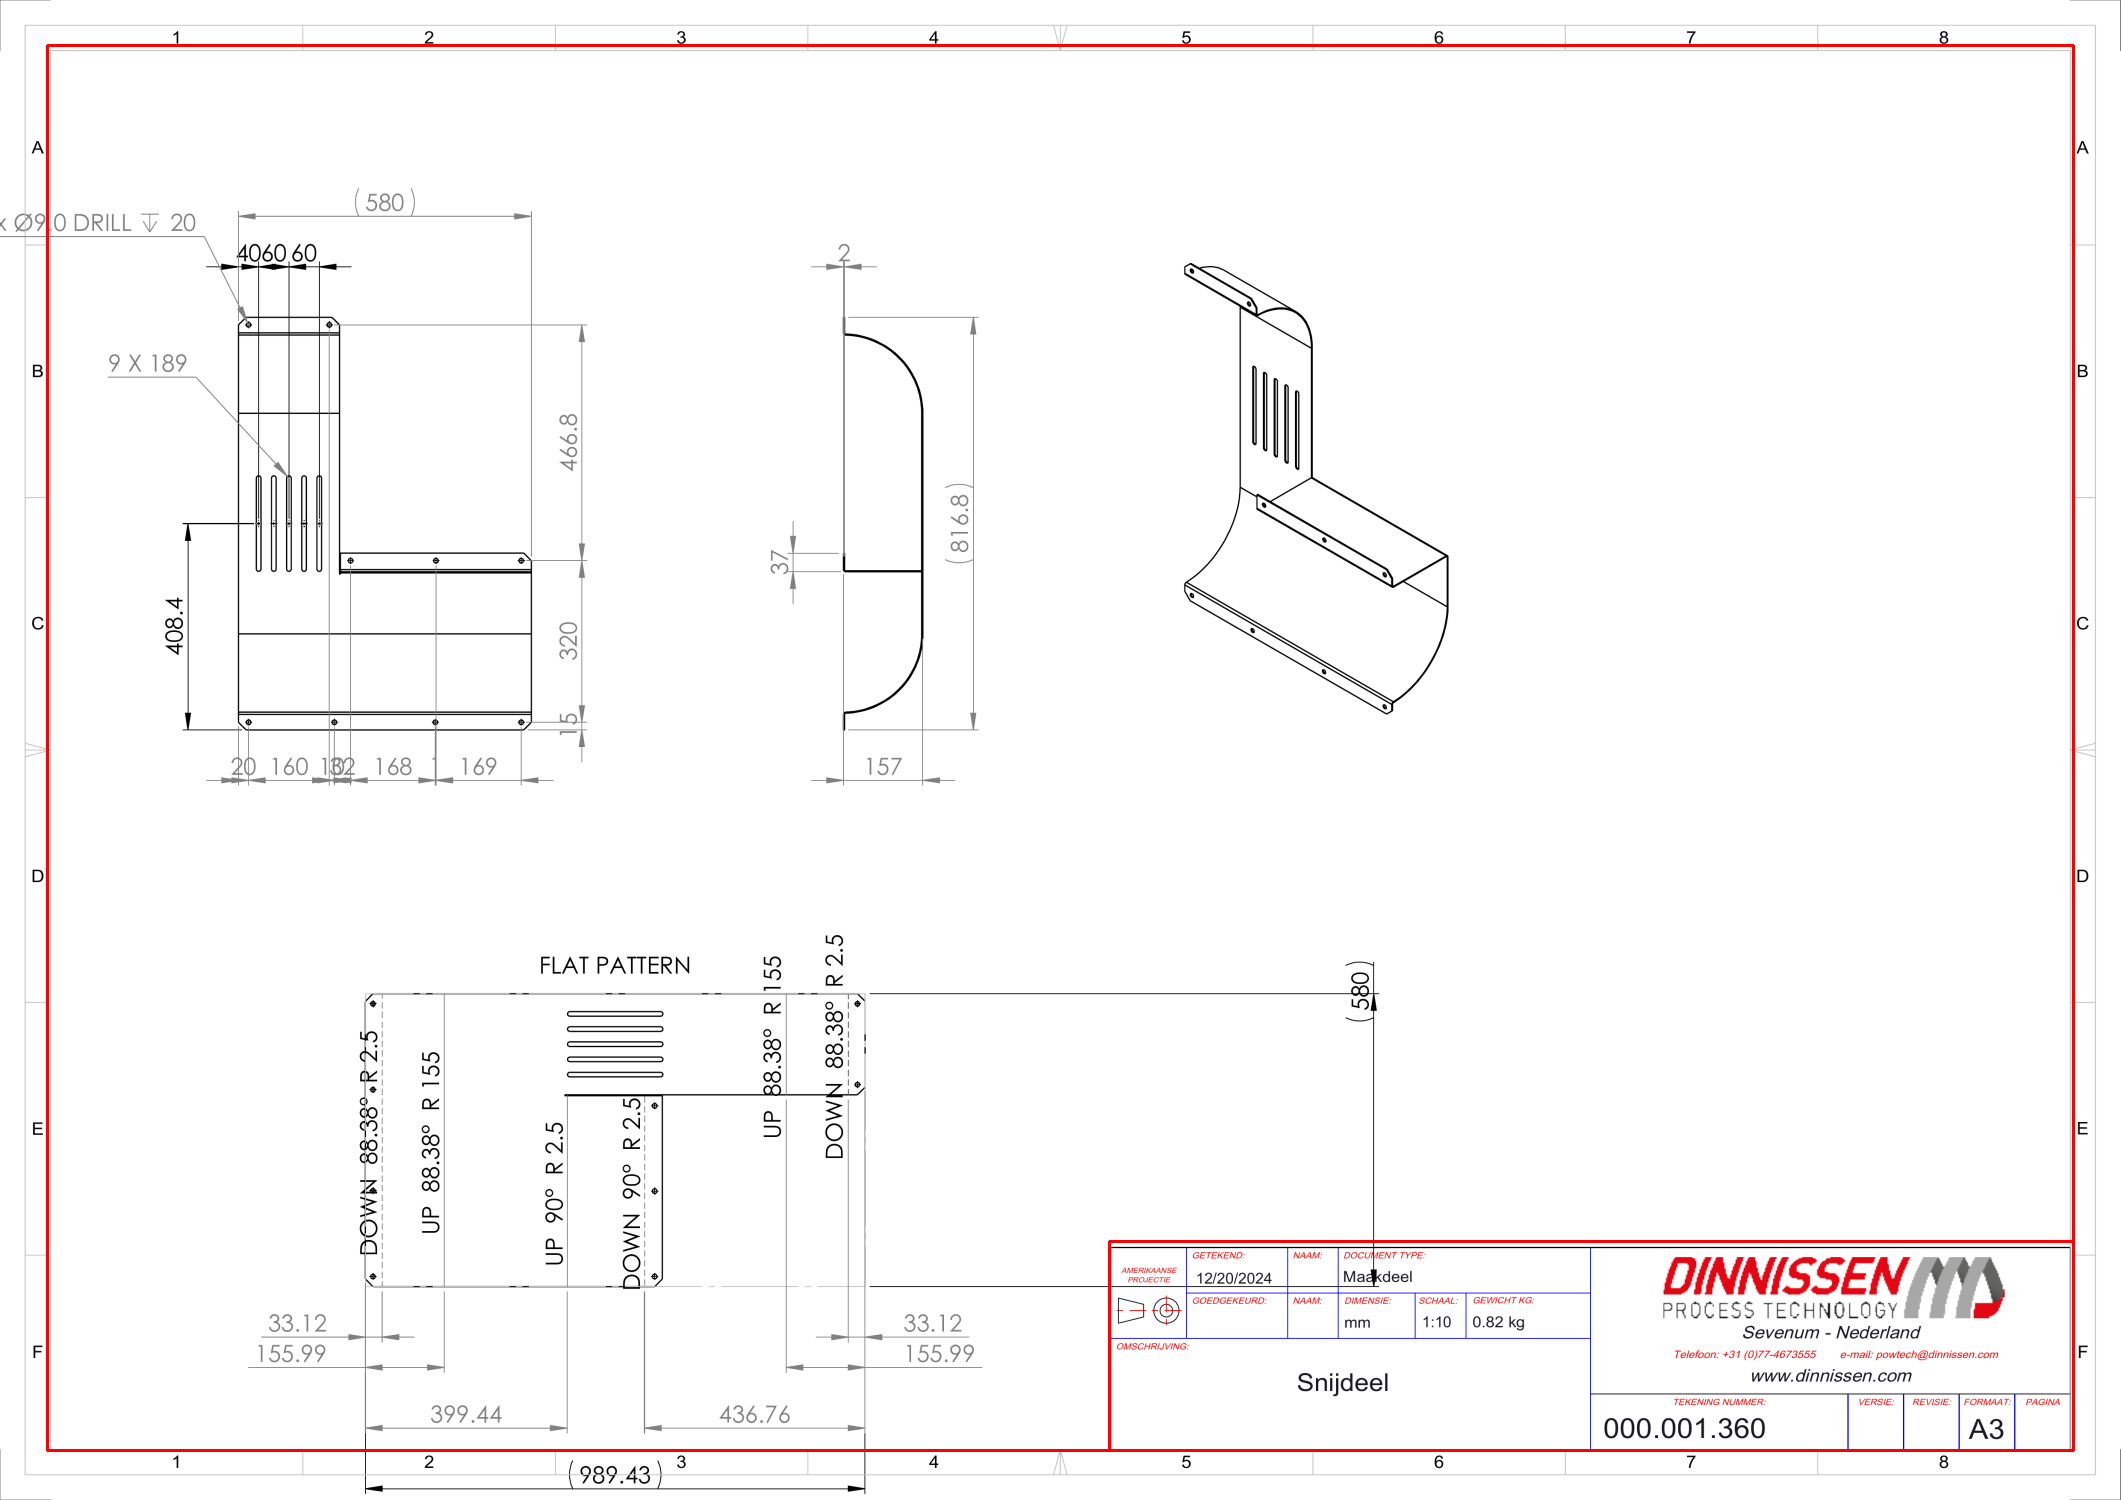

In [2]:
img_comp = img.copy()
im_h, im_w, _ = img.shape

sorted_indices, contours, hierarchy_area = detect_objects(img)
title_contours, line_90, data = detect_probable_title_sections(img, return_states=True)
ocr_result = data["ocr_result"]
mask = data["mask"]
inner_border_lines = data["inner_border_lines"]  #  0: Bottom, 1: Top, 2: Right, 3: Left
words = process_text(ocr_result, im_h, im_w)

border_1, border_2 = detect_borders(contours, sorted_indices, words)
contours = detect_text_tables(img, words, mask)
title_contours = title_contours + contours

boundary = get_boundary(border_1, border_2, inner_border_lines)
title_boundary = get_title_boundary(boundary, line_90, title_contours, words, im_h)

cv2.rectangle(img_comp, boundary[0], boundary[1], color, thickness)
cv2.rectangle(img_comp, title_boundary[0], title_boundary[1], color, thickness)

Image.fromarray(img_comp)

In [3]:
intersected_extended_lines, boundary_lines, boundary_title_block_lines, _ = detect_intersection_with_borders(img.copy(), boundary, title_boundary, True)

In [4]:
words

,page_idx,dimensions,orientation.value,orientation.confidence,language.value,language.confidence,block_idx,block_geometry,objectness_score.lines,artefacts,...,word_idx,value,confidence,objectness_score,crop_orientation.value,crop_orientation.confidence,x1,y1,x2,y2
index,,,,,,,,,,,,,,,,,,,,,
0,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,0,2,0.999433,0.317918,0,None,424.614258,31.262695,437.041992,45.761719
1,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,1,3,0.999938,0.322850,0,None,675.240234,31.262695,687.667969,43.690430
2,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,2,6,0.996881,0.327695,0,None,1433.332031,31.262695,1445.759766,43.690430
3,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,3,7,0.998115,0.317672,0,None,1686.029297,31.262695,1698.457031,43.690430
4,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,4,8,0.999765,0.316908,0,None,1938.726562,31.262695,1951.154297,45.761719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,88,5,0.999929,0.354405,0,None,1180.634766,1454.238281,1193.062500,1468.737305
89,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,89,6,0.999538,0.396152,0,None,1431.260742,1454.238281,1447.831055,1470.808594
90,0,"(1500, 2121)",None,None,None,None,0,"((0.0, 0.020841796874999985), (0.986328125, 0....",0.388943,[],...,90,7,0.996688,0.349713,0,None,1681.886719,1450.095703,1700.528320,1470.808594


(23, 23)


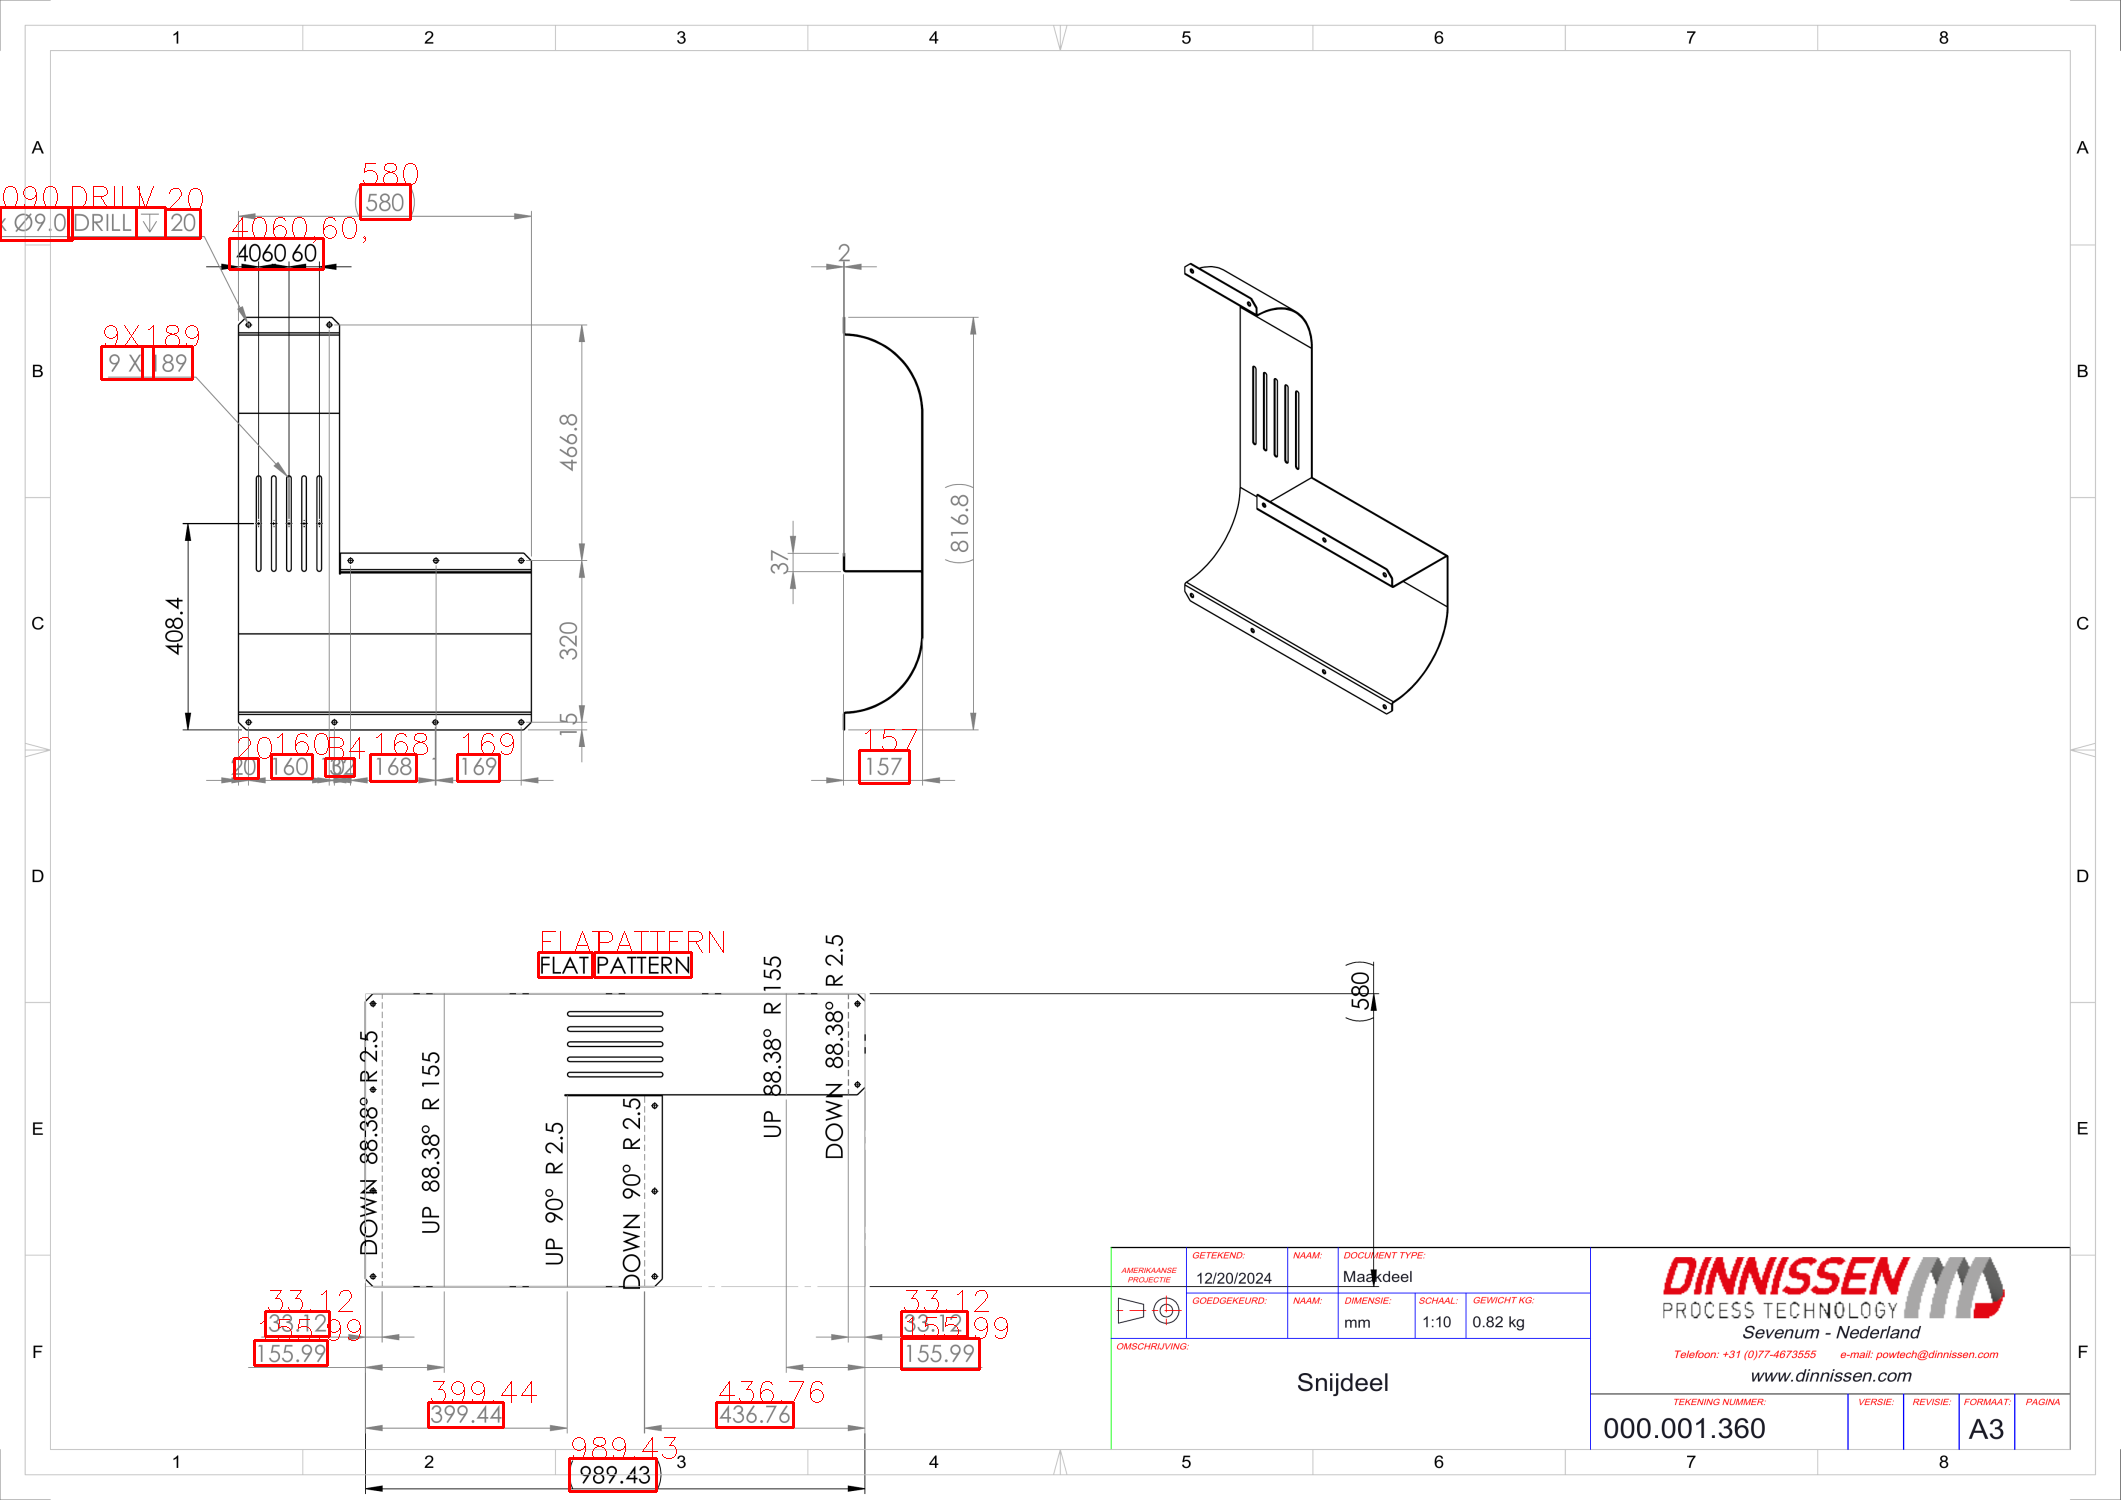

In [5]:
img_comp = img.copy()
words_copy = words.copy()

words_copy = words_copy.loc[
    ~words.value.isin(x_index_titles) &
    ~words.value.isin(y_index_titles) &
    (
        (words.x1 < boundary_title_block_lines[1][0])  # left
        | (words.y1 < boundary_title_block_lines[0][1])  # left
    )
]
print(words_copy.shape)
for idx, row in words_copy.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)
    cv2.putText(img_comp, f"{row['value']}", (bx1, by1), font, fontScale, color)

Image.fromarray(img_comp)

(1, 23)


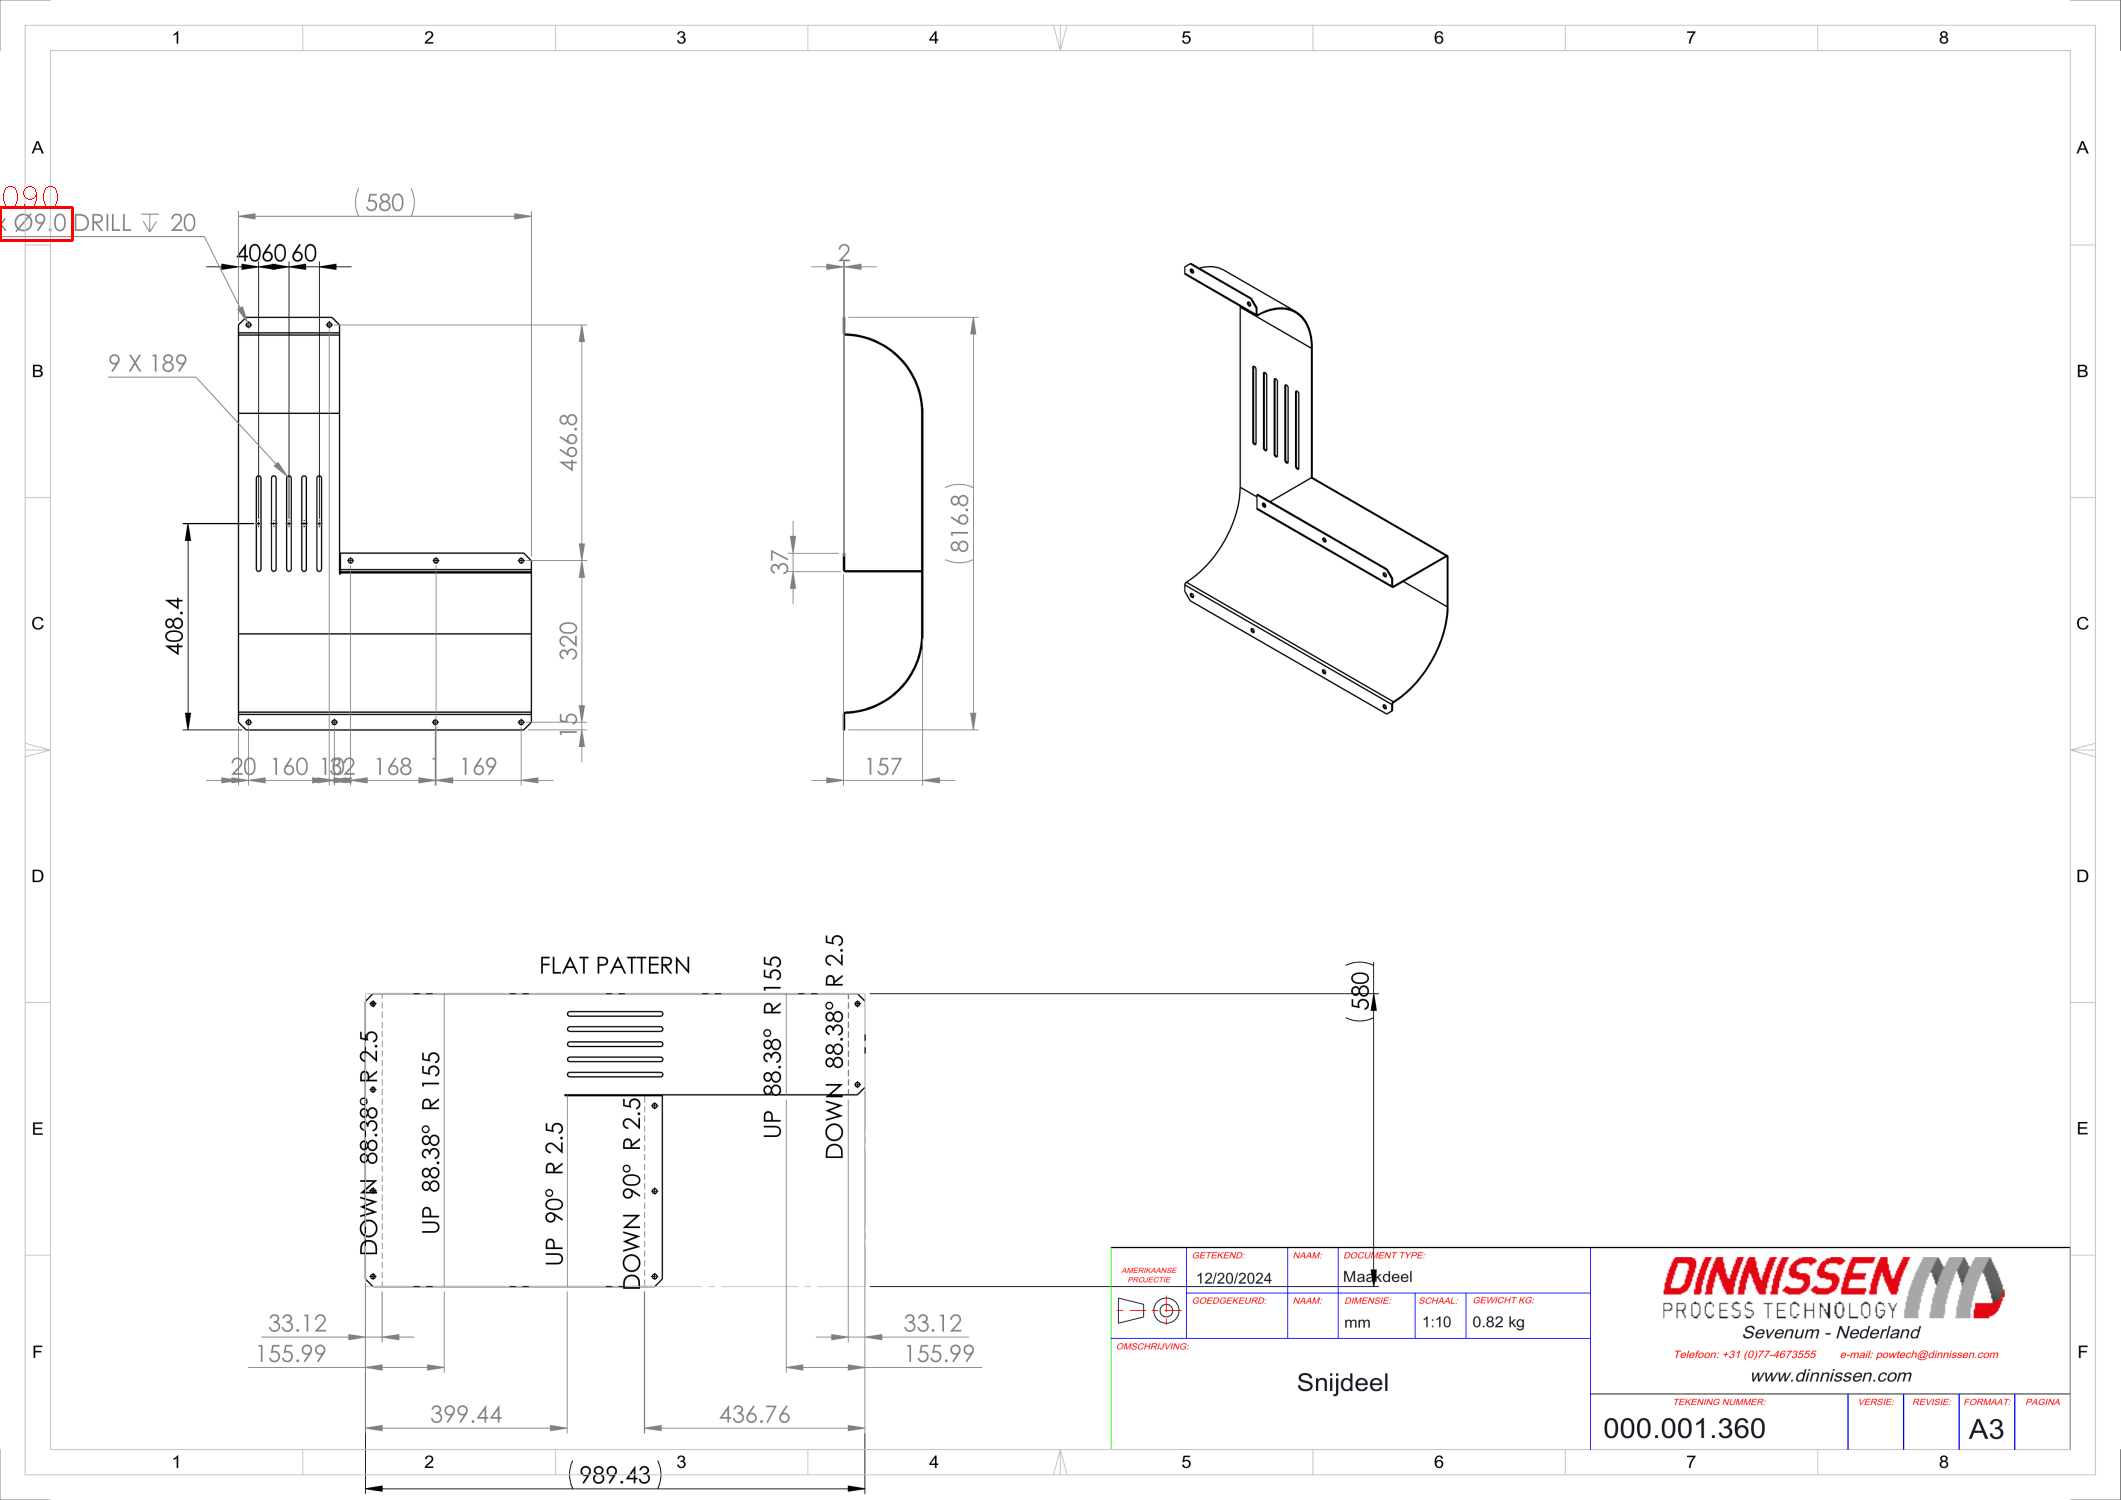

In [6]:
img_comp = img.copy()
words_copy = words_copy.copy()

words_copy = words_copy.loc[
    (words.x1 < boundary_lines[3][0]) & (words.x2 > boundary_lines[3][2])  # left
    | (words.x1 < boundary_lines[2][0]) & (words.x2 > boundary_lines[2][2])  # right
    | (words.y1 < boundary_lines[1][1]) & (words.y2 > boundary_lines[1][3])  # top
    | (words.y1 < boundary_lines[0][1]) & (words.y2 > boundary_lines[0][3])  # bottom
]
print(words_copy.shape)
for idx, row in words_copy.iterrows():
    bx1, by1, bx2, by2 = row[["x1", "y1", "x2", "y2"]].astype(int)
    cv2.rectangle(img_comp, (bx1, by1), (bx2, by2), (255, 0, 0), 2)
    cv2.putText(img_comp, f"{row['value']}", (bx1, by1), font, fontScale, color)

Image.fromarray(img_comp)